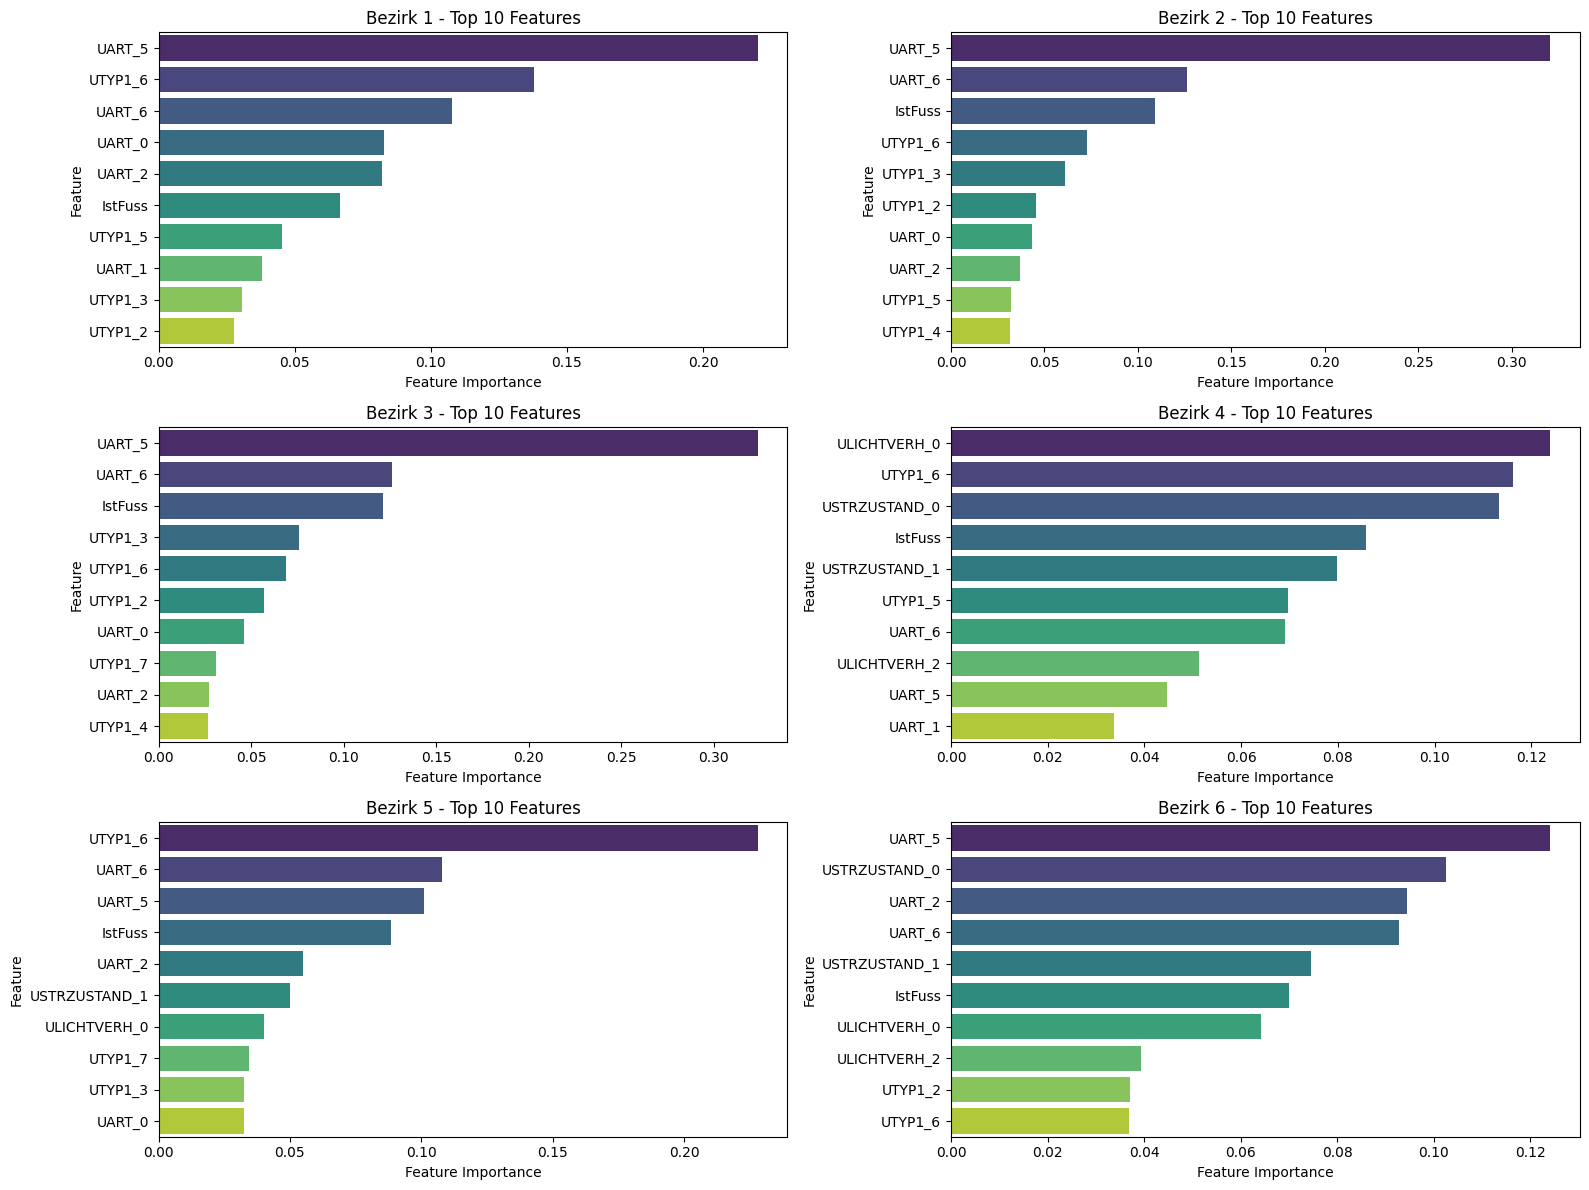

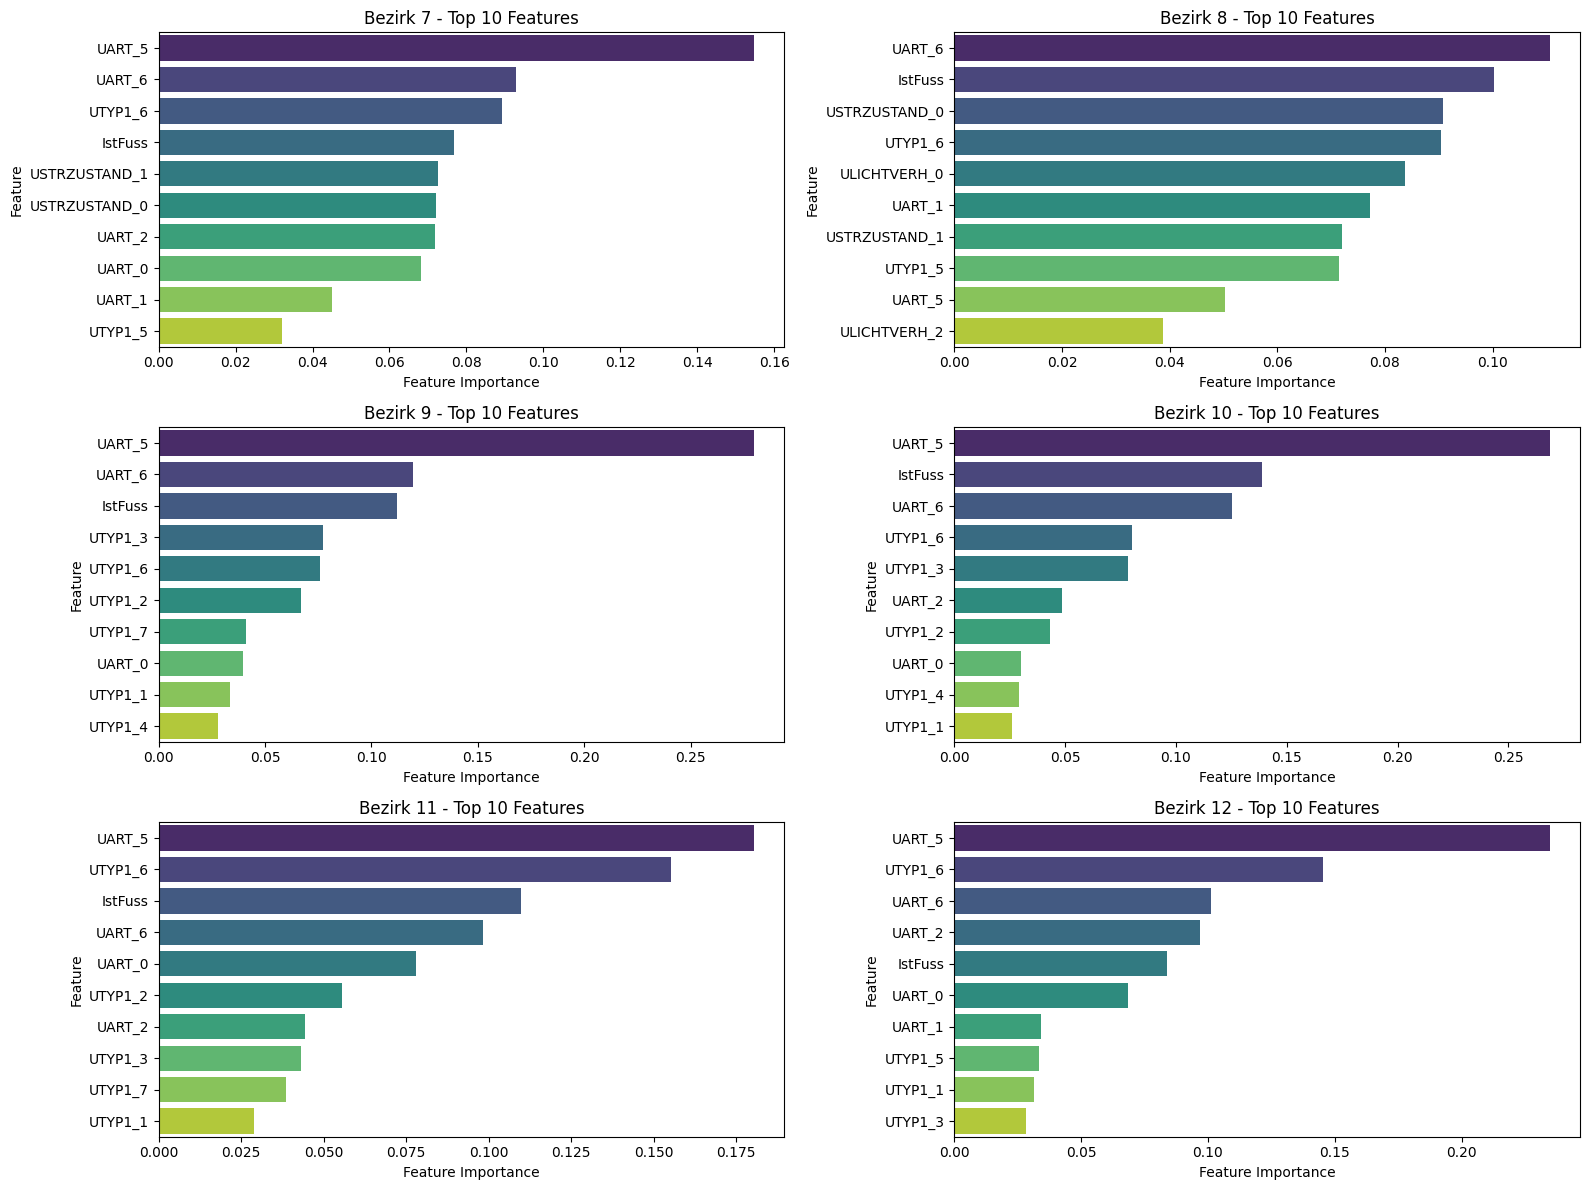

In [1]:
import pandas as pd  # Für die Datenverarbeitung und Tabellenmanipulation
import seaborn as sns  # Für die Visualisierung von Daten mit schönen Diagrammen
import matplotlib.pyplot as plt  # Für grundlegende Diagrammerstellung
import joblib  # Zum Laden und Speichern von Modellen und Daten
import numpy as np  # Für numerische Berechnungen und Array-Manipulationen
from sklearn.ensemble import RandomForestClassifier  # Für die Erstellung eines Random-Forest-Klassifikationsmodells

# -----------------------------
# Lade Daten und Agglomerative-Labels
# -----------------------------
df_encoded = pd.read_csv("hierarchisch_encoded_data.csv")

# Lade die Cluster-Labels
cluster_labels = np.load("hierarchisch_final_clusters_pro_bezirk.npy")

# Füge Cluster-Labels zum DataFrame hinzu
df_encoded['Cluster'] = cluster_labels

# Entferne Noise-Punkte (-1), da sie keiner Cluster-Zugehörigkeit haben
df_encoded_subset = df_encoded[df_encoded['Cluster'] != -1]

# -----------------------------
# Trainiere Random Forest Modell pro Bezirk
# -----------------------------
bezirke = df_encoded_subset['BEZ'].unique()

# Sortiere die Bezirke nach ihrer numerischen Reihenfolge
bezirke = sorted(bezirke, key=lambda x: int(x))  # Konvertiere Bezirk als Ganzzahl für die Sortierung

# Setze eine Liste für die visualisierten Feature-Importances
all_feature_importances = []

# Gehe jeden Bezirk durch
for bezirk in bezirke:
    df_bezirk = df_encoded_subset[df_encoded_subset['BEZ'] == bezirk]
    
    # Wenn nur ein Cluster, überspringen
    if len(df_bezirk['Cluster'].unique()) == 1:
        print(f"Bezirk {bezirk} hat nur 1 Cluster, daher kann Random Forest nicht berechnet werden.")
        continue
    
    # Zielvariable (Cluster) und Features (X)
    X = df_bezirk.drop(columns=['Cluster', 'BEZ'])
    y = df_bezirk['Cluster']
    
    # Trainiere Random Forest
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    rf.fit(X, y)

    # Berechne die Feature-Importances
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
    
    # Filtere Features mit Bedeutung größer als 0
    feature_importances = feature_importances[feature_importances['Importance'] > 0]
    
    # Wenn keine wichtigen Features vorhanden sind, überspringe
    if feature_importances.empty:
        print(f"Bezirk {bezirk}: Keine signifikanten Features gefunden.")
        continue

    # Füge das DataFrame für diesen Bezirk zur Gesamtübersicht hinzu
    feature_importances['Bezirk'] = bezirk
    all_feature_importances.append(feature_importances)

# Fasse alle Feature-Importances zusammen
all_feature_importances = pd.concat(all_feature_importances)

# -----------------------------
# Visualisierung der Top Features für jeden Bezirk
# -----------------------------
# Berechne die Anzahl der benötigten Zeilen und Spalten für das Subplot-Layout
# Anzahl der Bezirke
num_bezirke = len(bezirke)

# Aufteilen in zwei Gruppen
mid = num_bezirke // 2
bezirke_1 = bezirke[:mid]
bezirke_2 = bezirke[mid:]

# Funktion zum Erstellen der Plots
def plot_feature_importance(bezirke_subset, filename):
    n_plots = len(bezirke_subset)
    n_cols = 2  # 2 Spalten
    n_rows = int(np.ceil(n_plots / n_cols))  # Zeilen berechnen

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, bezirk in enumerate(bezirke_subset):
        top_features = all_feature_importances[all_feature_importances['Bezirk'] == bezirk].nlargest(10, 'Importance')

        if top_features.empty:
            continue

        ax = axes[i]
        sns.barplot(x='Importance', y='Feature', data=top_features, ax=ax, palette='viridis', hue='Feature', legend=False)
        ax.set_title(f"Bezirk {bezirk} - Top 10 Features")
        ax.set_xlabel('Feature Importance')
        ax.set_ylabel('Feature')

    # Entferne ungenutzte Subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Erstes Bild (erste Hälfte der Bezirke)
plot_feature_importance(bezirke_1, "output/plots/Top_10_Features_Bezirke_1.png")

# Zweites Bild (zweite Hälfte der Bezirke)
plot_feature_importance(bezirke_2, "output/plots/Top_10_Features_Bezirke_2.png")
